Following code process the file velib dataset.mmap 

input: velib_dataset.mmap, velib_metadata.json
=instant updates of all stations for period 2023-2025, sorted by (station, time), with necessary metadatas

output: mini version interpolated on a time grid (freq=hour)
-> weight 100 Mega only !
-> fast and easy manipulation with xarray

<details>
<summary>🧠 Voir le code (cliquer pour dérouler)</summary>

```python


import numpy as np
import json
from tqdm import tqdm
from raw_data.by_station.load_metadata import load_velib_metadata

# === Chargement ===
meta = load_velib_metadata()
data = meta["data"]
station_offsets = meta["station_offsets"]

# === Période cible ===
t0 = np.datetime64("2023-01-01T00")
t1 = np.datetime64("2024-12-31T23")
times = np.arange(t0, t1 + np.timedelta64(1, "h"), np.timedelta64(1, "h"))
n_hours = len(times)
n_stations = len(station_offsets)
n_features = 4  # vm_sum, vae_sum, flux_plus, flux_minus

# === Allocation du memmap ===
mmap_path =  "raw_data/by_station/mini_velib_dataset.mmap"
velib = np.memmap(mmap_path, dtype=np.int8, mode="w+", shape=(n_stations, n_hours, n_features))
capacities = {}

# === Conversion minutes absolues → datetime64[h] ===
origin = np.datetime64("2023-01-01T00")
def temps_to_datetime64(temps_minutes):
    return origin + temps_minutes.astype("timedelta64[m]")

# === Traitement station par station ===
for i, (station_id, months) in enumerate(tqdm(station_offsets.items())):
    print(f"operating station {i}")
    # --- récupération bornes globales ---
    month_keys = sorted(months.keys())
    start = months[month_keys[0]][0]
    end   = months[month_keys[-1]][1]

    # --- lecture bloc station ---
    block = data[start:end]

    t_abs = block["temps_absolu"].astype(np.int64)
    t_all = temps_to_datetime64(t_abs)
    vm_all = (
        block["vm_disponibles"]
        + block["vm_indisponibles"]
        + block["vm_disponibles_station_plus"]
        + block["vm_indisponibles_station_plus"]
    ).astype(np.int16)

    vae_all = (
        block["vae_disponibles"]
        + block["vae_indisponibles"]
        + block["vae_disponibles_plus"]
        + block["vae_indisponibles_plus"]
    ).astype(np.int16)

    # === 1️⃣ Calcul des flux bruts ===
    total = vm_all + vae_all
    cap = total + block["diapason_disponibles"].astype(np.int16) 
    delta_tot = np.diff(total, prepend=total[0])
    flux_plus_raw = np.clip(delta_tot, 0, 127).astype(np.int8)
    flux_minus_raw = np.clip(-delta_tot, 0, 127).astype(np.int8)

    # === 2️⃣ Agrégation horaire des flux ===
    # conversion des timestamps en indices d'heure (0, 1, 2, ...)
    hour_index = ((t_all - t0) / np.timedelta64(1, "h")).astype(int)
    valid = (hour_index >= 0) & (hour_index < n_hours)
    hour_index = hour_index[valid]
    flux_plus_binned = np.bincount(hour_index, weights=flux_plus_raw[valid], minlength=n_hours)
    flux_minus_binned = np.bincount(hour_index, weights=flux_minus_raw[valid], minlength=n_hours)

    # === 3️⃣ Interpolation des niveaux ===
    t_float = t_all.astype("datetime64[m]").astype(np.float64)
    times_float = times.astype("datetime64[h]").astype(np.float64) * 60  # minutes
    vm_interp = np.interp(times_float, t_float, vm_all)
    vae_interp = np.interp(times_float, t_float, vae_all)

    # === 4️⃣ Bloc final ===
    vm_i8 = np.clip(vm_interp, 0, 127).astype(np.int8)
    vae_i8 = np.clip(vae_interp, 0, 127).astype(np.int8)
    flux_plus_i8 = np.clip(flux_plus_binned, 0, 127).astype(np.int8)
    flux_minus_i8 = np.clip(flux_minus_binned, 0, 127).astype(np.int8)

    block_out = np.stack(
        [vm_i8, vae_i8, flux_plus_i8, flux_minus_i8],
        axis=-1
    )
    velib[i, :, :] = block_out

    # --- capacité max ---
    capacities[str(station_id)] = int(np.max(cap))

# === flush sur disque ===
velib.flush()

print("✅ Base horaire mmap créée :", velib.shape)
print("✅ Capacités stations :", len(capacities))
print("✅ Fichier :", mmap_path)

import pandas as pd
spatial_datas = pd.read_csv("prepare_data/spatial_datas.csv", dtype = {"code_station": str})

# créer un dict {station_id: (lat, lon)}
coors_dict = dict(zip(spatial_datas["code_station"], 
                      zip(spatial_datas["latitude"], spatial_datas["longitude"])))


# 3️⃣ Défaut si station absente (au sud-ouest de Paris)
default_coords = (48.75, 2.3)

# 4️⃣ Récupérer les coordonnées pour toutes les stations connues
coords_all = {
    station: coors_dict.get(station, default_coords)
    for station in station_offsets.keys()
}

# 5️⃣ Séparer en deux dictionnaires : latitude / longitude
latitudes = {sid: lat for sid, (lat, lon) in coords_all.items()}
longitudes = {sid: lon for sid, (lat, lon) in coords_all.items()}


import json
from datetime import datetime

meta_mini = {
    "station_ids": list(station_offsets.keys()),       # id des stations
    "capacities": capacities,                          # capacités max
    "columns": ["vm_sum", "vae_sum", "flux_plus", "flux_minus"],
    "time_start": str(t0),
    "time_end": str(t1),
    "time_freq": "1H",                                 # fréquence horaire
    "created_at": str(datetime.now()),
    "latitudes": {sid: latitudes[sid] for sid in list(station_offsets.keys())},
    "longitudes": {sid: longitudes[sid] for sid in list(station_offsets.keys())},
    "data_file": mmap_path
}

with open("raw_data/by_station/mini_velib_metadata.json", "w") as f:
    json.dump(meta_mini, f, indent=2)


</details> ```


In [2]:
print("✅ Base horaire mmap créée :", velib.shape)
print("✅ Capacités stations :", len(capacities))
print("✅ Fichier :", mmap_path)

✅ Base horaire mmap créée : (1551, 17544, 4)
✅ Capacités stations : 1551
✅ Fichier : raw_data/by_station/mini_velib_dataset.mmap


Small tutorial for using the new database

In [1]:
from raw_data.by_station.mini_load_metadata import load_mini

ds = load_mini()
ds

c:\Users\arman\Collaboration_Smovengo\Collaboration_Smovengo\algo\raw_data\by_station\mini_load_metadata.py:24: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = xr.DataArray(


<xarray.Dataset>
Dimensions:     (station: 1551, time: 17544)
Coordinates:
  * station     (station) <U12 '000000002' '10001' ... '9999970' '9999980'
    latitude    (station) float64 48.75 48.75 48.75 48.87 ... 48.89 48.75 48.75
    longitude   (station) float64 2.3 2.3 2.3 2.35 2.354 ... 2.224 2.206 2.3 2.3
    capacite    (station) int32 16 63 0 19 49 18 30 19 ... 26 21 43 30 23 38 0 0
  * time        (time) datetime64[ns] 2023-01-01 ... 2024-12-31T23:00:00
Data variables:
    vm_sum      (station, time) int8 2 2 2 2 2 2 2 2 2 2 ... 0 0 0 0 0 0 0 0 0 0
    vae_sum     (station, time) int8 11 11 11 11 11 11 11 11 ... 0 0 0 0 0 0 0 0
    flux_plus   (station, time) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    flux_minus  (station, time) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

In [28]:
import numpy as np
import xarray as xr
from tqdm import tqdm

# Sélection des 24*7 premières heures
subset_time = ds.time[:24*7]  # 168 heures
vm = ds.vm_sum.sel(time=subset_time)
vae = ds.vae_sum.sel(time=subset_time)
cap = ds.capacite
reste = cap.values[:, None] - vm.values - vae.values

# Grille spatiale
lats = ds.latitude.values
lons = ds.longitude.values
lon_edges = np.linspace(lons.min(), lons.max(), 65)  # 200 pixels → 201 edges
lat_edges = np.linspace(lats.min(), lats.max(), 65)

t_steps = subset_time.size
grid_rgb = np.zeros((t_steps, 64, 64, 3), dtype=np.uint8)

for i in tqdm(range(t_steps)):
    vm_t = vm.isel(time=i).values
    vae_t = vae.isel(time=i).values
    reste_t = reste[:, i]

    # Comptage par pixel avec histogram2d
    vm_i, _, _ = np.histogram2d(lats, lons, bins=[lat_edges, lon_edges], weights=vm_t)
    vae_i, _, _ = np.histogram2d(lats, lons, bins=[lat_edges, lon_edges], weights=vae_t)
    reste_i, _, _ = np.histogram2d(lats, lons, bins=[lat_edges, lon_edges], weights=reste_t)

    # On clippe à 255 pour tenir dans uint8
    grid_rgb[i, :, :, 0] = np.clip(reste_i, 0, 255).astype(np.uint8)
    grid_rgb[i, :, :, 1] = np.clip(vm_i, 0, 255).astype(np.uint8)
    grid_rgb[i, :, :, 2] = np.clip(vae_i, 0, 255).astype(np.uint8)

# Coordonnées centrées sur les pixels
lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2

# Xarray
grid_ds = xr.DataArray(
    grid_rgb,
    dims=('time', 'lat', 'lon', 'channel'),
    coords={'time': subset_time, 'lat': lat_centers, 'lon': lon_centers, 'channel': ['R','G','B']}
)


  0%|          | 0/168 [00:00<?, ?it/s]

100%|██████████| 168/168 [00:01<00:00, 165.45it/s]


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.ndimage import gaussian_filter

# --- Fonction de normalisation RGB par pixel ---
def normalize_rgb(arr):
    arr_disp = arr.astype(np.float32)
    sum_c = arr_disp.sum(axis=-1, keepdims=True)
    arr_disp = np.where(sum_c != 0, 255 * arr_disp / sum_c, 255)
    return arr_disp.astype(np.uint8)

# --- Fonction pour lisser l'image ---
def smooth_rgb(arr, sigma=2, n_iter=2):
    arr_smooth = arr.astype(np.float32).copy()
    for _ in range(n_iter):
        for i in range(3):
            arr_smooth[..., i] = gaussian_filter(arr_smooth[..., i], sigma=sigma)
    return arr_smooth.astype(np.uint8)

# --- Préparer la figure ---
fig, axes = plt.subplots(1, 2, figsize=(12,6))
im0 = axes[0].imshow(smooth_rgb(normalize_rgb(grid_ds.values[0]), sigma=2, n_iter=2),
                     origin='lower', interpolation='nearest')
axes[0].set_title("Original lissé")
im1 = axes[1].imshow(normalize_rgb(approx_rgb[0]),
                     origin='lower', interpolation='nearest')
axes[1].set_title("Approximation Wavelet")

# --- Fonction de mise à jour pour l'animation ---
def update(frame):
    im0.set_data(smooth_rgb(normalize_rgb(grid_ds.values[frame]), sigma=2, n_iter=2))
    im1.set_data(normalize_rgb(grid_ds.values[frame]))
    return im0, im1

# --- Création de l'animation ---
anim = FuncAnimation(fig, update, frames=grid_ds.shape[0], interval=100, blit=False)

# --- Sauvegarde en GIF ---
writer = PillowWriter(fps=10)
anim.save("velib_animation.gif", writer=writer)

plt.close(fig)
print("Animation enregistrée sous velib_animation.gif")


C:\Users\arman\AppData\Local\Temp\ipykernel_16956\1254796410.py:10: RuntimeWarning: invalid value encountered in divide
  arr_disp = np.where(sum_c != 0, 255 * arr_disp / sum_c, 255)
C:\Users\arman\AppData\Local\Temp\ipykernel_16956\1254796410.py:10: RuntimeWarning: invalid value encountered in divide
  arr_disp = np.where(sum_c != 0, 255 * arr_disp / sum_c, 255)


Animation enregistrée sous velib_animation.gif


In [7]:
import pywt
import numpy as np

def threshold_coeffs(coeffs, method='sigma', value=3.0):
    """
    Applique un seuil aux coefficients de détails pour ne garder que les significatifs.
    - method='sigma' : seuil = value * std(coeffs de détails)
    - method='hard' : seuil = valeur fixe
    """
    coeffs_thresh = [coeffs[0]]  # approximation reste inchangée

    for d in coeffs[1:]:
        d_thresh = {}
        for k, v in d.items():
            if method == 'sigma':
                sigma = np.std(v)
                t = value * sigma
            else:
                t = value
            # Seuil hard : zéro si |v| < t
            d_thresh[k] = np.where(np.abs(v) < t, 0, v)
        coeffs_thresh.append(d_thresh)
    return coeffs_thresh

coeffs_channels_sig = {}
for c in ['R','G','B']:
    data = grid_ds.sel(channel=c).astype(np.float32).values
    coeffs = pywt.wavedecn(data, wavelet='db2', level=2)
    # Ne garder que les coefficients significatifs
    coeffs_sig = threshold_coeffs(coeffs, method='sigma', value=3.0)
    coeffs_channels_sig[c] = coeffs_sig
    
    print(f"Canal {c} : mémoire ondelette totale = {coeffs_mem_mb(coeffs_sig):.2f} MB")


Canal R : mémoire ondelette totale = 26.78 MB
Canal G : mémoire ondelette totale = 26.78 MB
Canal B : mémoire ondelette totale = 26.78 MB


In [ ]:
import pywt

# Exemple sur le canal vert (vm_sum)
data = grid_ds.sel(channel='G').values  # shape = (t, lat, lon)

# Ondelette 3D discrète
coeffs = pywt.wavedecn(data, wavelet='db2', level=2)  # 2 niveaux de décomposition

# coeffs est une liste : [approximation, {détails}]


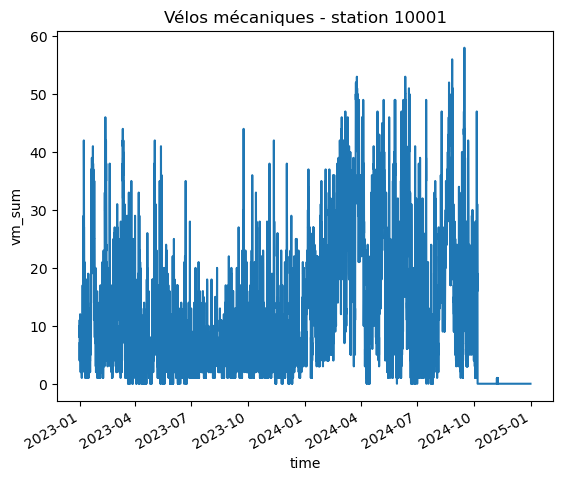

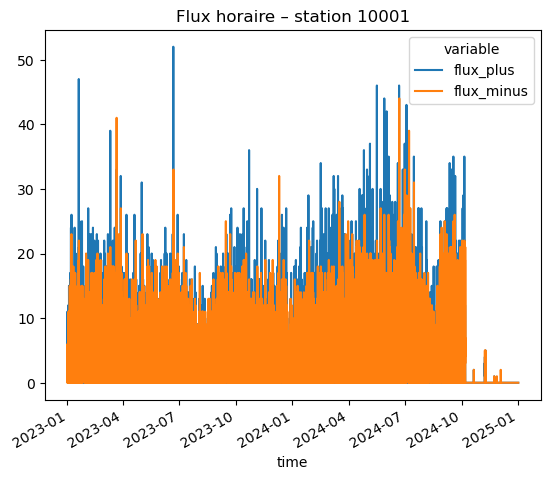

In [2]:
import matplotlib.pyplot as plt

# Exemple 1 : évolution vm_sum pour une station
station_idx = '10001'
ds["vm_sum"].sel(station=station_idx).plot()
plt.title(f"Vélos mécaniques - station {station_idx}")
plt.show()

# Exemple 2 : plot 2 colonnes sur le mm graphe (plus compliqué)
ds.isel(station=ds.get_index("station").get_loc(station_idx))[
    ["flux_plus", "flux_minus"]
].to_array().plot.line(x="time")

plt.title(f"Flux horaire – station {station_idx}")
plt.show()

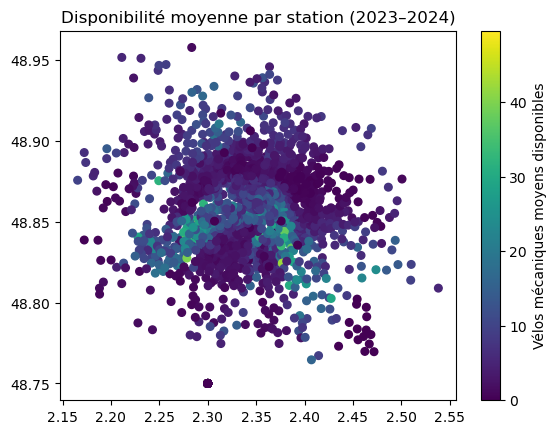

In [3]:
daily_mean = ds["vm_sum"].resample(time="1D").mean()
mean_day = daily_mean.mean(dim="time")

plt.scatter(ds.longitude, ds.latitude, c=mean_day, cmap="viridis", s=30)
plt.colorbar(label="Vélos mécaniques moyens disponibles")
plt.title("Disponibilité moyenne par station (2023–2024)")
plt.show()

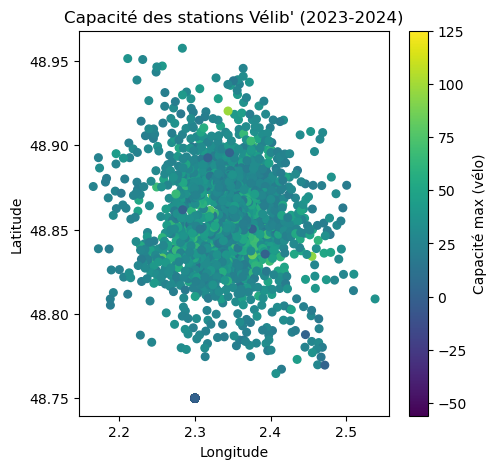

In [8]:
import matplotlib.pyplot as plt

# Coordonnées
lats = ds.latitude.values    # shape (station,)
lons = ds.longitude.values  # shape (station,)
caps = ds.capacite.values   # shape (station,)

plt.figure(figsize=(5, 5))
sc = plt.scatter(lons, lats, c=caps, cmap="viridis", s=30)
plt.colorbar(sc, label="Capacité max (vélo)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Capacité des stations Vélib' (2023-2024)")
plt.show()


Attention petit bug, pour 4/5 stations tres bizares 
qui ont dépassé la capacité max attendue (stations éphèmeres ??)

In [13]:
caps = ds.capacite.values       # numpy array shape (station,)
stations = ds.station.values    # station IDs correspondants

idx_min = caps.argmin()
idx_max = caps.argmax()

print("Station avec capacité min :", stations[idx_min], "→", caps[idx_min])
print("Station avec capacité max :", stations[idx_max], "→", caps[idx_max])


Station avec capacité min : 32051 → -56
Station avec capacité max : 16200 → 125


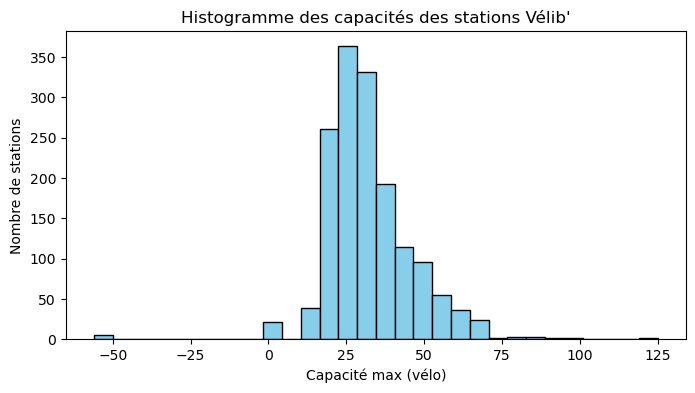

In [14]:
import matplotlib.pyplot as plt

caps = ds.capacite.values  # numpy array shape (station,)

plt.figure(figsize=(8,4))
plt.hist(caps, bins=30, color='skyblue', edgecolor='k')
plt.xlabel("Capacité max (vélo)")
plt.ylabel("Nombre de stations")
plt.title("Histogramme des capacités des stations Vélib'")
plt.show()


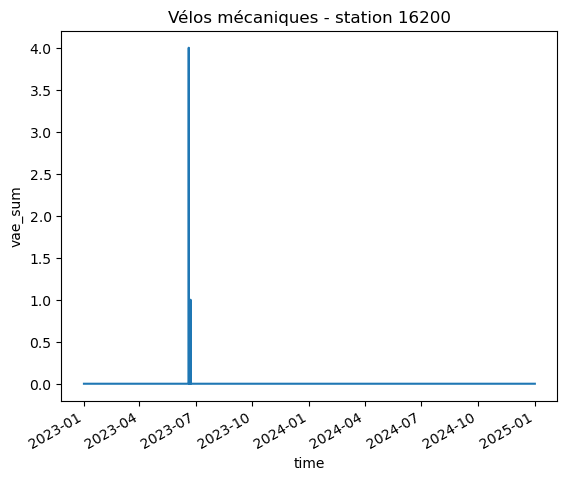

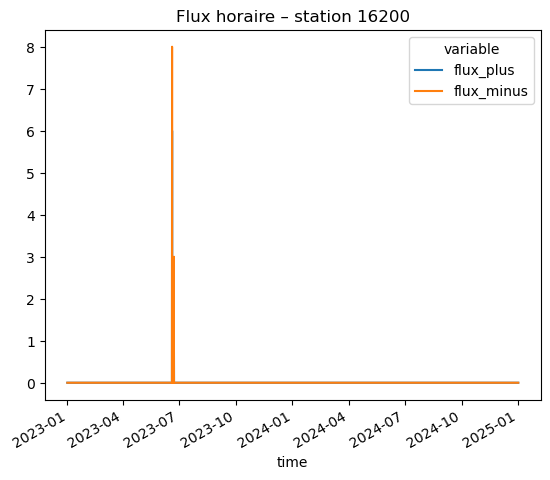

In [17]:
import matplotlib.pyplot as plt

# Exemple 1 : évolution vm_sum pour une station
station_idx = '16200'
ds["vae_sum"].sel(station=station_idx).plot()
plt.title(f"Vélos mécaniques - station {station_idx}")
plt.show()

# Exemple 2 : plot 2 colonnes sur le mm graphe (plus compliqué)
ds.isel(station=ds.get_index("station").get_loc(station_idx))[
    ["flux_plus", "flux_minus"]
].to_array().plot.line(x="time")

plt.title(f"Flux horaire – station {station_idx}")
plt.show()